<a href="https://colab.research.google.com/github/ChardyBalla/Chardy/blob/main/Copy_of_RFM_Analysis_Homework_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RFM Analysis Homework

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The dataset under study contains credit card transactions from the State of Oklahoma. It includes information on purchases made through the purchase card programs administered by the state and higher educational institutions. The purchase card information is updated monthly after the end of every month. As such, July information is added in August, August in September, and so on and so forth.

In a brief, here's the data description:
- Dataset contains around 440k credit card transactions.
- Each row in the dataset refers to a credit card transaction by a cardholder.
- Each cardholder belongs to an agency.
- Each transaction has the following information:
    - cardholder name
    - agency
    - amount
    - transaction date
    - merchant name (vendor)
    - merchant category
    - description of the expense

## 1. Load and clean the dataset.
Hints:
a. Transaction date and posted date should be in datetime format
b. Create a "full name" column
c. Do not include transactions made by agencies (customer name = agency)
d. Check for outliers (negative amount, refunds?)
## 2. Perform an RFM analysis and identify key customer segments (assume that the current date is 2014-07-01).
Hints:
a. In this case, we expect a one-to-one relationship between the customers and transactions (i.e. every swipe of the credit card is 1 transaction).
b. Use quartiles
## 3. Provide some key insights and recommendations to encourage customers to spend more with the credit cards.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load and clean the data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Refocus Module/Jupyter Notebook-20230501T012835Z-001/Jupyter Notebook/datasets/res_purchase_card_(pcard)_fiscal_year_2014_3pcd-aiuu.csv',
                   parse_dates=['Transaction Date', 'Posted Date'])

In [4]:
df.head()

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,2013-07-30,2013-07-31,SHERATON
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,2013-07-29,2013-07-31,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...
3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,2013-07-30,2013-07-31,"GROCERY STORES,AND SUPERMARKETS"
4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,2013-07-30,2013-07-31,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT..."


## 1. Load and clean the dataset.

a. Create a "full name" column
b. Do not include transactions made by agencies (customer name = agency)
c. Check for outliers (negative amount, refunds?)

In [44]:
# full name column
df['full_name'] = df['Cardholder Last Name'] + ', ' + df['Cardholder First Initial']

In [45]:
# remove agency (Do not include transactions made by agencies (customer name = agency))
df = df[df['Agency Number'].astype(str)!=df['Cardholder Last Name']]

In [46]:
# remove negative amounts
df = df[df['Amount']>0]

# RFM Analysis

In [48]:
import datetime

current_date = datetime.datetime(2014, 7, 1)
current_date

datetime.datetime(2014, 7, 1, 0, 0)

### Recency

In [15]:
# get max transaction date per customer
df_latest_invoice = df.groupby('full_name')['Transaction Date'].max()
df_latest_invoice.head()

full_name
15000, 1   2014-03-10
24100, 2   2014-03-14
42000, 4   2014-06-04
44600, 4   2013-07-08
48000, 4   2014-06-30
Name: Transaction Date, dtype: datetime64[ns]

In [49]:
# get number of days between latest invoice date and current date
# .dt.days means that we only get the actual days (not decimal)
df_recency = (current_date - df_latest_invoice).dt.days
df_recency.head()

full_name
15000, 1    113
24100, 2    109
42000, 4     27
44600, 4    358
48000, 4      1
Name: Transaction Date, dtype: int64

### Frequency

In [50]:
# get frequency (count)
df_frequency = df.groupby('full_name')['full_name'].count()

### Monetary

In [51]:
# get the total amount (sum of all amounts)
df_monetary = df.groupby('full_name')['Amount'].sum()

## RFM Scores

We now merge these tables into a single dataframe. We put each series together in a dictionary and use `pd.DataFrame`

In [52]:
df_rfm = pd.DataFrame({'recency':df_recency, 'frequency':df_frequency, 'monetary':df_monetary})

#### Calculate RFM scores. Use quantiles (0.25, 0.50, 0.75) to map the scores from 1 to 4

In [53]:
quantiles = df_rfm.quantile(q=[0.25, 0.50, 0.75])
quantiles

,recency,frequency,monetary
0.25,5.00,12.0,2229.170
0.50,14.00,34.0,7874.830
0.75,54.25,89.0,24446.665


Using the quantiles function, we can get our thresholds for segmentation.

1. For recency score (lower is better):
- Score = 1; quantile between 0-0.25
- Score = 2; quantile between 0.25-0.5
- Score = 3; quantile between 0.5-0.75
- Score = 4; quantile between 0.75 - 1

<br>
2. For frequency and monetary score (higher is better):
- Score = 1; quantile between 0.75 - 1
- Score = 2; quantile between 0.5-0.75
- Score = 3; quantile between 0.25-0.5
- Score = 4; quantile between 0-0.25

<br>

#### Recency Score

In [54]:
# create a dictionary with the recency quantiles
recency_dict = quantiles['recency'].to_dict()
recency_dict

{0.25: 5.0, 0.5: 14.0, 0.75: 54.25}

In [55]:
# create a function to calculate recency score
def recency_score(recency, recency_dict):
    if recency <= recency_dict[0.25]:
        # recency_score = 1 if recency is between 0-0.25 quantile
        return '1'
    elif recency <= recency_dict[0.5]:
        # recency_score = 2 if recency is between 0.25-0.5 quantile
        return '2'
    elif recency <= recency_dict[0.75]:
        # recency_score = 3 if recency is between 0.5-0.75 quantile
        return '3'
    else:
        # recency_score = 4 if recency is between 0.75-1 quantile
        return '4'

df_rfm['recency_score'] = df_rfm['recency'].apply(recency_score, args=(recency_dict,))
df_rfm.head()

,recency,frequency,monetary,recency_score
full_name,,,,
"15000, 1",113,NaN,NaN,4
"24100, 2",109,NaN,NaN,4
"42000, 4",27,NaN,NaN,3
"44600, 4",358,NaN,NaN,4
"48000, 4",1,NaN,NaN,1


### Frequency Score

In [56]:
# create a dictionary with the frequency quantiles
frequency_dict = quantiles['frequency'].to_dict()
frequency_dict

{0.25: 12.0, 0.5: 34.0, 0.75: 89.0}

In [57]:
# create a function to calculate frequency score
def frequency_score(frequency, frequency_dict):
    if frequency <= frequency_dict[0.25]:
        # frequency_score = 4 if frequency is between 0-0.25 quantile
        return '4'
    elif frequency <= frequency_dict[0.5]:
        # frequency_score = 3 if frequency is between 0.25-0.5 quantile
        return '3'
    elif frequency <= frequency_dict[0.75]:
        # frequency_score = 2 if frequency is between 0.5-0.75 quantile
        return '2'
    else:
        # frequency_score = 1 if frequency is between 0.75-1 quantile
        return '1'

df_rfm['frequency_score'] = df_rfm['frequency'].apply(frequency_score, args=(frequency_dict,))
df_rfm.head()

,recency,frequency,monetary,recency_score,frequency_score
full_name,,,,,
"15000, 1",113,NaN,NaN,4,1
"24100, 2",109,NaN,NaN,4,1
"42000, 4",27,NaN,NaN,3,1
"44600, 4",358,NaN,NaN,4,1
"48000, 4",1,NaN,NaN,1,1


### Monetary Score

In [58]:
# create a dictionary with the monetary quantiles
monetary_dict = quantiles['monetary'].to_dict()
monetary_dict

{0.25: 2229.17, 0.5: 7874.830000000001, 0.75: 24446.665}

In [59]:
# create a function to calculate monetary score
def monetary_score(monetary, monetary_dict):
    if monetary <= monetary_dict[0.25]:
        # monetary_score = 4 if monetary is between 0-0.25 quantile
        return '4'
    elif monetary <= monetary_dict[0.5]:
        # monetary_score = 3 if monetary is between 0.25-0.5 quantile
        return '3'
    elif monetary <= monetary_dict[0.75]:
        # monetary_score = 2 if monetary is between 0.5-0.75 quantile
        return '2'
    else:
        # monetary_score = 1 if monetary is between 0.75-1 quantile
        return '1'

df_rfm['monetary_score'] = df_rfm['monetary'].apply(monetary_score, args=(monetary_dict,))
df_rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score
full_name,,,,,,
"15000, 1",113,NaN,NaN,4,1,1
"24100, 2",109,NaN,NaN,4,1,1
"42000, 4",27,NaN,NaN,3,1,1
"44600, 4",358,NaN,NaN,4,1,1
"48000, 4",1,NaN,NaN,1,1,1


#### Concatenate the RFM Scores

In [60]:
# Concatenate the three created columns earlier
df_rfm['rfm_score'] = df_rfm['recency_score'] + df_rfm['frequency_score'] + df_rfm['monetary_score']
df_rfm.head(10)

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score
full_name,,,,,,,
"15000, 1",113,NaN,NaN,4,1,1,411
"24100, 2",109,NaN,NaN,4,1,1,411
"42000, 4",27,NaN,NaN,3,1,1,311
"44600, 4",358,NaN,NaN,4,1,1,411
"48000, 4",1,NaN,NaN,1,1,1,111
"53000, 5",264,NaN,NaN,4,1,1,411
"53100, 5",32,NaN,NaN,3,1,1,311
"60500, 6",32,NaN,NaN,3,1,1,311
"75000, 7",320,NaN,NaN,4,1,1,411


#### Provide insights, recommendations, analysis. Use visualizations if necessary.



# To provide insights and recommendations based on the RFM analysis, we can analyze the different customer segments based on their RFM scores. Let's examine the segments and make recommendations accordingly.

Segment Analysis:

Potential Loyalists (RFM Score: X1X): This segment consists of customers who have made high monetary value purchases but have not been very frequent recently. They show potential to become loyal customers. Recommendations for this segment include implementing customer retention strategies such as personalized follow-ups, special offers for their next purchase, and product recommendations based on their previous purchases.


Recent Customers (RFM Score: XX1): These are customers who have made frequent purchases recently but with a lower monetary value. They are showing engagement but haven't spent significantly. Recommendations for this segment include upselling and cross-selling strategies to increase the average transaction value, providing product bundles or incentives for larger purchases, and offering loyalty program incentives to encourage repeat purchases.


At-Risk Customers (RFM Score: X4X or 4XX): This segment includes customers who haven't made recent purchases or have low frequency and monetary value. They are at risk of churn or becoming inactive. Recommendations for this segment include targeted re-engagement campaigns, personalized win-back offers, and surveys to understand the reasons behind their decreased activity.


Low-Value Customers (RFM Score: 444): These customers have low recency, frequency, and monetary value. They have not engaged much and haven't spent significantly. Recommendations for this segment include focusing on acquisition strategies to attract new customers, improving product offerings to meet their needs, and exploring partnerships to expand the customer base.

In [61]:
print("Best Customers")
len(df_rfm[df_rfm['rfm_score']=='111'])

Best Customers


576

# High-Value Customers (RFM Score: 111):
These are the most valuable customers who have recently made frequent purchases with high monetary value. They are highly engaged and loyal. Recommendations for this segment include offering personalized rewards, exclusive discounts, and targeted promotions to maintain their loyalty and encourage them to spend even more.

In [62]:
 segment_counts = {'best_customers (111)': len(df_rfm[df_rfm['rfm_score']=='111']),
                  'loyal_customers (X1X)': len(df_rfm[df_rfm['frequency_score']=='1']),
                  'big_spenders (XX1)': len(df_rfm[df_rfm['monetary_score']=='1']),
                  'almost_lost (311)': len(df_rfm[df_rfm['rfm_score']=='311']),
                  'lost_good_customers (411)': len(df_rfm[df_rfm['rfm_score']=='411']),
                  'lost_cheap_customers (444)': len(df_rfm[df_rfm['rfm_score']=='444'])}

# Recommendations:

# Personalization:
Use the insights from RFM analysis to personalize marketing campaigns, offers, and communications based on each customer segment's characteristics. This will enhance the customer experience and increase engagement.

# Loyalty Programs:
Implement a tiered loyalty program that offers exclusive benefits and rewards based on customer RFM scores. This will incentivize customers to move up the loyalty ladder and increase their spending.

# Cross-Selling and Upselling:
Leverage the RFM analysis to identify opportunities for cross-selling and upselling. Recommend relevant products or services to customers based on their previous purchase

In [41]:
df_counts = pd.DataFrame(segment_counts.values(), index=segment_counts.keys(), columns=['counts'])
df_counts

,counts
best_customers (111),575
loyal_customers (X1X),1282
big_spenders (XX1),1301
almost_lost (311),86
lost_good_customers (411),44
lost_cheap_customers (444),622


Text(0, 0.5, '# Customers per Segment')

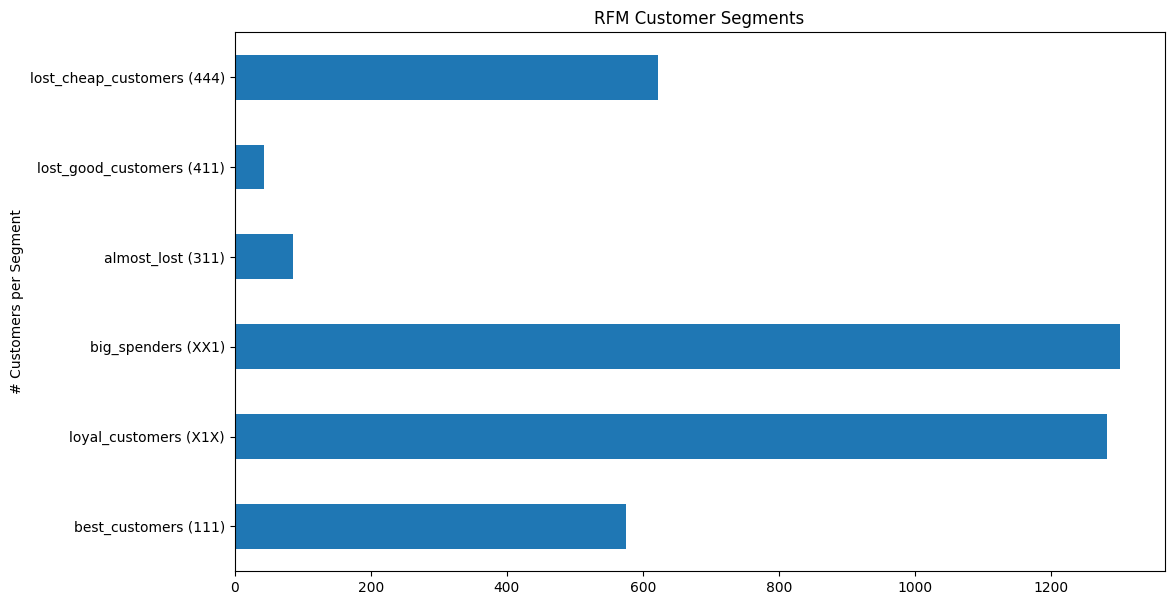

In [63]:
fig, ax = plt.subplots(figsize=(12,7))
df_counts.plot(kind='barh', ax=ax, legend=False)
ax.set_title('RFM Customer Segments')
ax.set_ylabel('# Customers per Segment')

# Visualizations:

To visualize the RFM segments, you can use various charts and graphs such as bar plots, pie charts, or scatter plots. Here are a few examples:

# RFM Segment Distribution:
Create a bar plot or pie chart to visualize the distribution of customers across different RFM segments. This will provide an overview of the customer composition and highlight the dominant segments.

# RFM Chart:
Create a Chart to visualize the average monetary value or frequency for each RFM segment. This will help identify the segments that contribute the most revenue or have the highest engagement.

# Customer Journey Analysis:
Plot a line chart or scatter plot to show the average recency, frequency, and monetary value of customers over time. This will help identify trends and patterns in customer behavior.

# Comparison with Previous Period:
Create a line chart or stacked bar plot to compare the RFM segments and their distribution with the previous period. This will show whether customer engagement and value have improved or declined over time.

# Customer Persona Analysis:
Analyze the characteristics and demographics of customers in each RFM segment. This can be done through demographic profiling, clustering analysis, or customer persona creation. It will help tailor marketing strategies and communication to specific customer segments.